## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №19

Реализовать алгоритмы Стэкинг, Бэгин и Бустинг.  
При реализации алгоритмов не использовать готовые решения.  
За сровнение взять CatBoostClassifier как базовая метрика качества. Сравнить результат с реализацией своих ансамблей.  
Для однозначности и интерпретируемости результатов использовать приложенный набор данных. 

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns

from math import nan

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

RANDOM_STATE = 42

# Функция генерации файла результатов
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

Загрузить данные

In [29]:
df = pd.read_csv('winequality-white.csv', sep=';')

Проверить наличие NaN в значениях признаков, при необходимости осуществить замену  
Выполнить удаление дубликатов

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [36]:
print(f'Количество записей-дубликатов: {df[df.duplicated()].shape[0]}')

#TODO: проверить наличие противоречивых записей (с различным значением целевого признака при совпадении всех прочих )
cols = df.columns.tolist()[:-1]
df.groupby(cols)['quality'].count().sort_values(ascending=False).head(10)

# Удалить дубликаты сохраняя первую запись
#df = df.drop_duplicates(keep='first')
#print(f'Набор данных после удаления дубликатов: {df.shape}')

Количество записей-дубликатов: 937


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density  pH    sulphates  alcohol
7.0            0.15              0.28         14.7            0.051      29.0                 149.0                 0.99792  2.96  0.39       9.0        8
7.3            0.19              0.27         13.9            0.057      45.0                 155.0                 0.99807  2.94  0.41       8.8        8
7.4            0.16              0.30         13.7            0.056      33.0                 168.0                 0.99825  2.90  0.44       8.7        7
6.8            0.18              0.30         12.8            0.062      19.0                 171.0                 0.99808  3.00  0.52       9.0        7
7.4            0.19              0.30         12.8            0.053      48.5                 229.0                 0.99860  3.14  0.49       9.1        6
7.6            0.20              0.30         14.2            0.056      53

Построить корреляционную матрицу признаков  
Проанализировать зависимости

<AxesSubplot: >

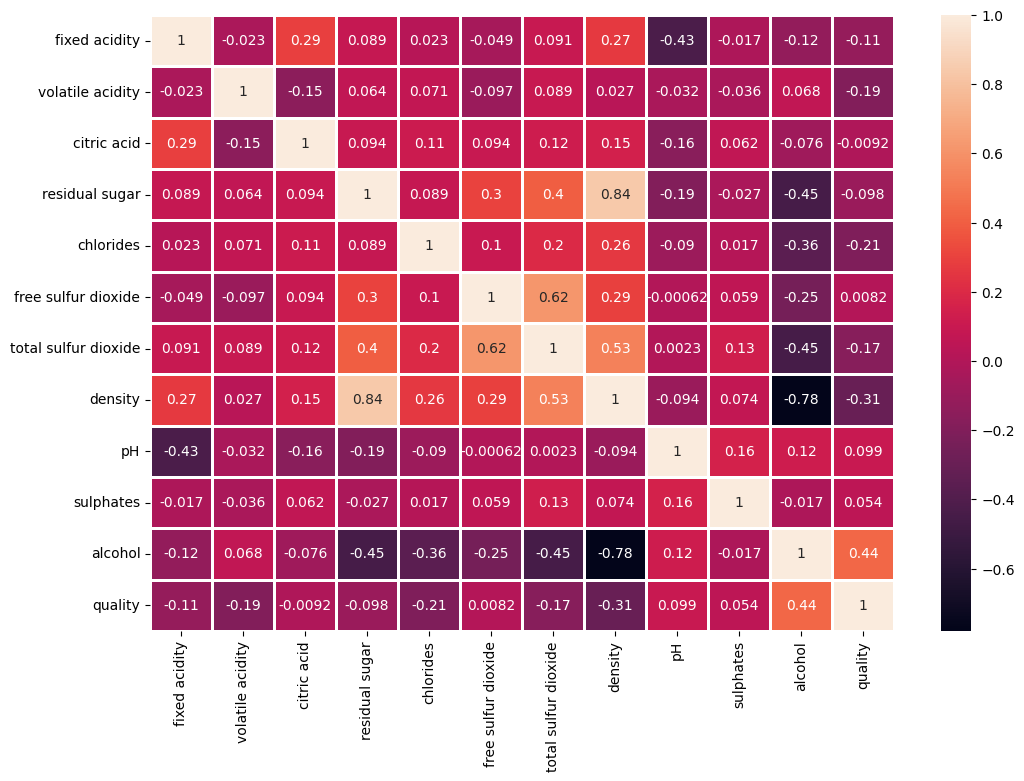

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, linewidths=1)

- Наблюдается существенная корреляция признака _alcohol_ c большей частью остальных признаков и главное - с целевым признаком _quality_ !!!
Считаю целесообразным удалить данный признак из набора данных
- Признак Общего диоксида серы (total sulfur dioxide) включает в себя свободную (free sulfur dioxide) и связанную форму, Но именно свободная форма оказывает влияние на вкус и запах вина !!!
Считаю целесообразным удалить признак Общего диоксида серы из-за его существенной корреляции с признаком свободной формы.

In [3]:
# Удалить признаки total_sulfur_dioxede и alcohol
df.drop(['total sulfur dioxide','alcohol'], axis=1, inplace=True)

Визуализировать аномальные значения признаков

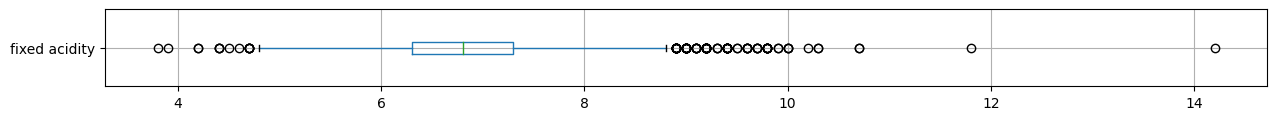

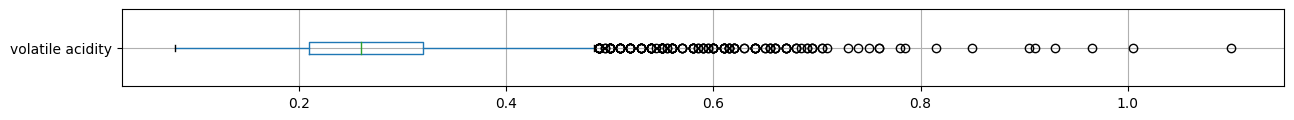

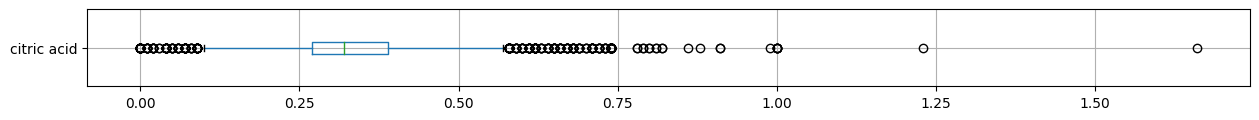

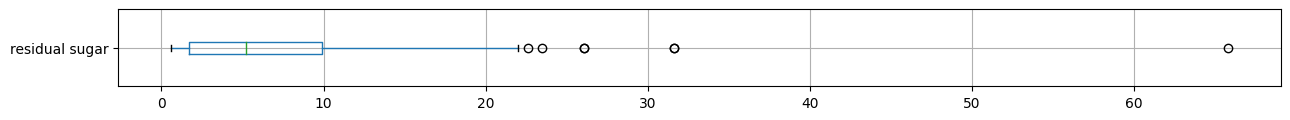

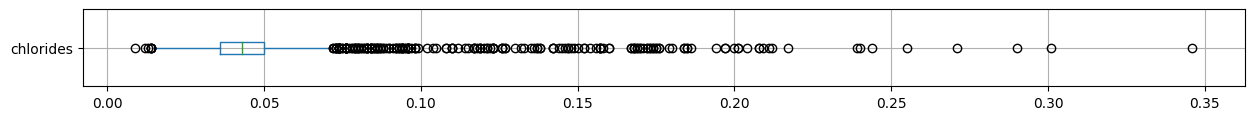

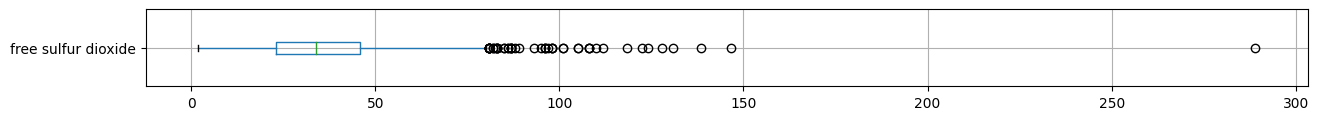

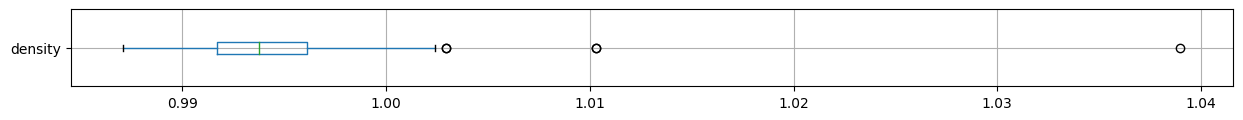

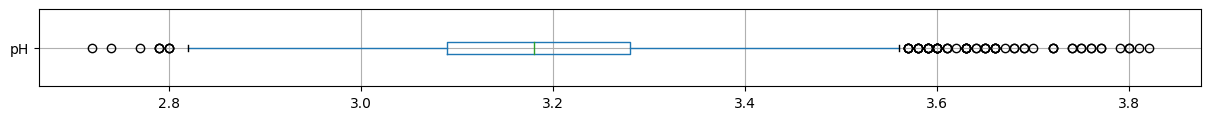

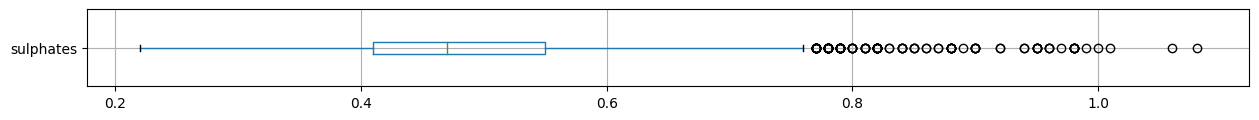

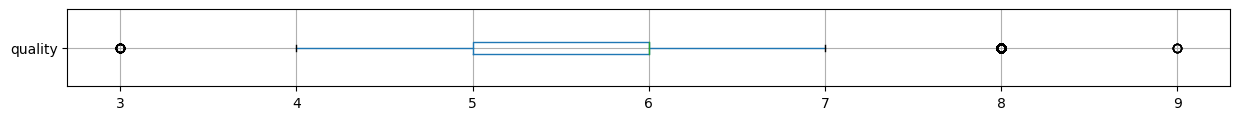

In [21]:
for col in df.columns:
    plt.figure(figsize=(15, 1))
    df[[col]].boxplot(vert=0 )

In [22]:
# Визуализировать распределение значений признаков
df.describe(include = "all").T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000
quality,4898.0,5.877909,0.885639,3.00000,5.000000,6.00000,6.0000,9.00000


In [23]:
# Удалить записи с максимальными значениями выбросов
'''
df.drop(df[df['fixed acidity'] > 11].index, inplace=True)
df.drop(df[df['volatile acidity'] > 1].index, inplace=True)
df.drop(df[df['citric acid'] > 1.2].index, inplace=True)
df.drop(df[df['residual sugar'] > 30].index, inplace=True)
df.drop(df[df['chlorides'] > 0.3].index, inplace=True)
df.drop(df[df['free sulfur dioxide'] > 140].index, inplace=True)
df.drop(df[df['density'] > 1.005].index, inplace=True)
'''

"\ndf.drop(df[df['fixed acidity'] > 11].index, inplace=True)\ndf.drop(df[df['volatile acidity'] > 1].index, inplace=True)\ndf.drop(df[df['citric acid'] > 1.2].index, inplace=True)\ndf.drop(df[df['residual sugar'] > 30].index, inplace=True)\ndf.drop(df[df['chlorides'] > 0.3].index, inplace=True)\ndf.drop(df[df['free sulfur dioxide'] > 140].index, inplace=True)\ndf.drop(df[df['density'] > 1.005].index, inplace=True)\n"

Выполнить скалирование данных. Подготовьте данные для обучения

array([[<AxesSubplot: title={'center': 'fixed acidity'}>,
        <AxesSubplot: title={'center': 'volatile acidity'}>,
        <AxesSubplot: title={'center': 'citric acid'}>],
       [<AxesSubplot: title={'center': 'residual sugar'}>,
        <AxesSubplot: title={'center': 'chlorides'}>,
        <AxesSubplot: title={'center': 'free sulfur dioxide'}>],
       [<AxesSubplot: title={'center': 'density'}>,
        <AxesSubplot: title={'center': 'pH'}>,
        <AxesSubplot: title={'center': 'sulphates'}>],
       [<AxesSubplot: title={'center': 'quality'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

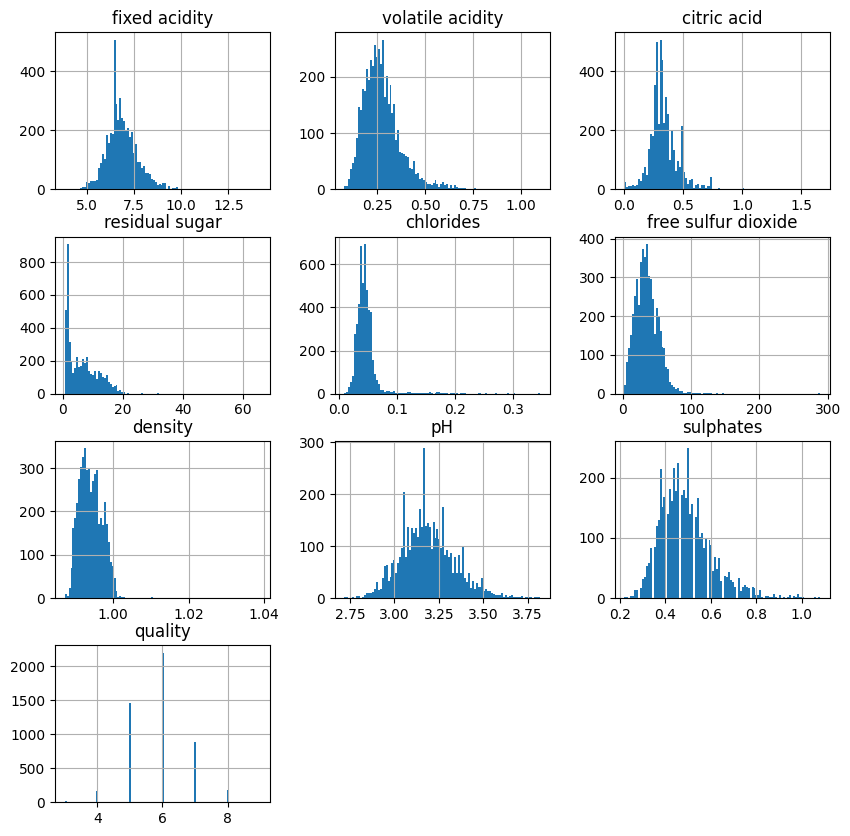

In [24]:
df.hist(bins=100, figsize=(10,10))

In [42]:
#scaler = MinMaxScaler()
scaler = StandardScaler()

X = df.drop('quality', axis=1)
y = df['quality']

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)


# Вычисление и отображение метрик алгоритмов классификации
lb = LabelBinarizer()
def print_metrics(y_src, y_pred):
    lb.fit(y_src)
    print('AUC на обучающей выборке: {:.3f}'
        .format(metrics.roc_auc_score(lb.transform(y_src), lb.transform(y_pred), average='macro')))
    print('Значения метрик для обучающей выборки:')
    print(metrics.classification_report(y_src,y_pred, zero_division=0))

### CatBoostClassifier

In [37]:
from catboost import CatBoostClassifier

cgb = CatBoostClassifier(verbose=False)
cgb.fit(X_train, y_train)

In [38]:
cgb_train_predicted = cgb.predict(X_train)
print_metrics(y_train, cgb_train_predicted)

AUC на обучающей выборке: 0.987
Значения метрик для обучающей выборки:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00        13
           4       1.00      0.98      0.99       131
           5       0.97      0.96      0.97      1099
           6       0.96      0.98      0.97      1654
           7       0.99      0.95      0.97       639
           8       1.00      0.98      0.99       132
           9       1.00      1.00      1.00         5

    accuracy                           0.97      3673
   macro avg       0.99      0.98      0.98      3673
weighted avg       0.97      0.97      0.97      3673



In [39]:
cgb_test_predicted = cgb.predict(X_test)
print_metrics(y_test, cgb_test_predicted)

AUC на обучающей выборке: 0.667
Значения метрик для обучающей выборки:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.58      0.22      0.32        32
           5       0.67      0.65      0.66       358
           6       0.64      0.76      0.69       544
           7       0.68      0.56      0.61       241
           8       0.76      0.37      0.50        43

    accuracy                           0.66      1225
   macro avg       0.56      0.43      0.46      1225
weighted avg       0.66      0.66      0.65      1225



## Реализация алгоритмов ассемблирования

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

# Базовые алгоритмы
rfc = RandomForestClassifier()
knc = KNeighborsClassifier()
lrc = LogisticRegression(max_iter=1000)
rgc = RidgeClassifier()

base_models = [rfc, knc, lrc, rgc]
meta_model = RidgeClassifier(0.001)

### 1. Стэкинг (Stacking)

In [19]:
# Пример реализации стэкинга моделей
class Stacking():  

    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
        self.base_models_prediction = None
        
    def fit(self, X, y, p=0.25, random_state=None):
        # разбиение данных для обучения базовых моделей метамодели
        X_base, X_meta, y_base, y_meta = train_test_split(X, y, test_size=p, random_state=random_state)
        # инициализация матрицы данных для обучения метамодели
        self.base_models_prediction = np.zeros((X_meta.shape[0], len(self.base_models)))

        # обучение базовых моделей и заполнение матрицы для обучения метамодели
        for i, model in enumerate(self.base_models):
            model.fit(X_base, y_base)
            self.base_models_prediction[:, i] = model.predict(X_meta)
                
        # обучение метамодели
        self.meta_model.fit(self.base_models_prediction, y_meta)
        return self
    
    def predict(self, X):
        # инициализация матрицы данных для метамодели
        X_meta = np.zeros((X.shape[0], len(self.base_models)))
        # заполнение матрицы для метамодели
        for i, m in enumerate(self.base_models):
            X_meta[:, i] = m.predict(X)
        
        return self.meta_model.predict(X_meta)

In [40]:
stc = Stacking(base_models, meta_model)
stc.fit(X_train, y_train, p=0.2, random_state=RANDOM_STATE)

stc_train_predicted = stc.predict(X_train)
print_metrics(y_train, stc_train_predicted)

AUC на обучающей выборке: 0.587
Значения метрик для обучающей выборки:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00       131
           5       0.83      0.81      0.82      1099
           6       0.62      0.97      0.76      1654
           7       0.00      0.00      0.00       639
           8       0.00      0.00      0.00       132
           9       0.00      0.00      0.00         5

    accuracy                           0.68      3673
   macro avg       0.21      0.25      0.22      3673
weighted avg       0.53      0.68      0.59      3673



In [41]:
stc_test_predicted = stc.predict(X_test)
print_metrics(y_test, stc_test_predicted)

AUC на обучающей выборке: 0.559
Значения метрик для обучающей выборки:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        32
           5       0.68      0.60      0.64       358
           6       0.52      0.87      0.65       544
           7       0.00      0.00      0.00       241
           8       0.00      0.00      0.00        43

    accuracy                           0.56      1225
   macro avg       0.20      0.24      0.21      1225
weighted avg       0.43      0.56      0.47      1225



### 1. Бэгинг (Bagging)